# **Анализ цен на авиабилеты по маршрутам между крупными городами России**

**Описание**:

Исследование посвящено сравнению цен на авиабилеты по разным маршрутам России.

Данные собраны с сайта Яндекс.Путешествия (с помощью Selenium) за 2025 год.

Таблица содержит колонки origin, dest (города отправления и назначения) и цены в рублях для пяти авиакомпаний: Россия, Аэрофлот, Победа, S7 Airlines, Уральские авиалинии.

In [ ]:
!pip install selenium airportsdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.7/913.7 kB 17.1 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import re
import airportsdata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [ ]:
# загружаем коды аэропортов
airports = airportsdata.load('IATA')

# отбираем только русские аэропорты
ru_airports = {code: info['city'].lower() for code, info in airports.items() if info['country'] == 'RU'}

# некоторые аэропорты в url ищутся не так как в названии, поэтому меняем
ru_airports["LED"] = 'saint-petersburg'
ru_airports["GOJ"] = 'nizhny-novgorod'
ru_airports["ASF"] = 'astrahan'

codes = ["SVO", "LED", "AER", "GOJ",
         "SVX", "KZN", "OVB", "UFA",
         "KRR", "ROV", "KHV", "VVO", "ASF"]

# формируем список все возможных комбинаций маршрутов
routes = [(o, d) for o in codes for d in codes if o != d]

# список авиакомпаний
companies = ["Россия", "Аэрофлот", "Победа", "S7 Airlines", "Уральские авиалинии"]

## Настройка ChromeOptions

In [ ]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")

options.add_argument("--user-data-dir=/tmp/selenium_profile")

service = Service()
driver = webdriver.Chrome(service=service, options=options)
wait = WebDriverWait(driver, 3)

In [ ]:
results = []

for origin, dest in routes:
    url = f"https://travel.yandex.ru/avia/routes/{ru_airports[origin]}--{ru_airports[dest]}"
    driver.get(url)

    # Ждём появления блока с ценами авиакомпаний
    xpath_block = "/html/body/div[1]/div/div[5]/div/div[2]/section/div[1]/div[2]/div[3]"
    try:
        block = wait.until(EC.presence_of_element_located((By.XPATH, xpath_block)))
    except Exception as e:
        print(f"Не удалось загрузить страницу или найти контейнер для маршрута {ru_airports[origin]}–{ru_airports[dest]}: {e}")
        continue

    # Инициализируем словарь с None по умолчанию
    data = {"origin": origin, "dest": dest}
    for comp in companies:
        data[comp] = None

    lines = block.text.splitlines()

    # Идём по парам строк: [название, цена]
    for i in range(0, len(lines), 2):

        name = lines[i].strip()

        # Если встречаем стоп-строку - выходим
        if "Стоимость рейсов с пересадками" in name:
            break

        # Берём цену из следующей строки (если она есть)
        if i + 1 >= len(lines):
            break

        price_text = lines[i + 1]

        # Очищаем текст цены
        price_digits = re.sub(r"\D", "", price_text)
        price = int(price_digits) if price_digits.isdigit() else None

        # Если это одна из нужных компаний - сохраняем
        if name in companies:
            data[name] = price

    results.append(data)

driver.quit()

#### В некоторых ситуациях видим, что не удалось найти направление - это связано с тем, что там не были найдены авиа рейсы, самолёты не летают по такому направлению

Можно заметить, что большая часть аэропортов на юге закрыта

In [ ]:
# Результат: список словарей с ценами по маршрутам
for entry in results:
    print(entry)

{'origin': 'SVO', 'dest': 'LED', 'Россия': 3724, 'Аэрофлот': 4954, 'Победа': 2409, 'S7 Airlines': 5514, 'Уральские авиалинии': None}
{'origin': 'SVO', 'dest': 'AER', 'Россия': 6859, 'Аэрофлот': 6320, 'Победа': 3439, 'S7 Airlines': 13312, 'Уральские авиалинии': 4102}
{'origin': 'SVO', 'dest': 'GOJ', 'Россия': 4353, 'Аэрофлот': None, 'Победа': None, 'S7 Airlines': None, 'Уральские авиалинии': None}
{'origin': 'SVO', 'dest': 'SVX', 'Россия': 9756, 'Аэрофлот': None, 'Победа': 3224, 'S7 Airlines': None, 'Уральские авиалинии': 3873}
{'origin': 'SVO', 'dest': 'KZN', 'Россия': 4719, 'Аэрофлот': 4587, 'Победа': None, 'S7 Airlines': 5832, 'Уральские авиалинии': None}
{'origin': 'SVO', 'dest': 'OVB', 'Россия': 8731, 'Аэрофлот': None, 'Победа': None, 'S7 Airlines': 11958, 'Уральские авиалинии': None}
{'origin': 'SVO', 'dest': 'UFA', 'Россия': 3731, 'Аэрофлот': None, 'Победа': None, 'S7 Airlines': 6417, 'Уральские авиалинии': None}
{'origin': 'SVO', 'dest': 'KHV', 'Россия': 16023, 'Аэрофлот': None,

In [ ]:
df = pd.DataFrame(results)
df.to_csv("data/flight_prices.csv", index=False)

  origin dest  Россия  Аэрофлот  Победа  S7 Airlines  Уральские авиалинии
0    SVO  LED  3724.0    4954.0  2409.0       5514.0                  NaN
1    SVO  AER  6859.0    6320.0  3439.0      13312.0               4102.0
2    SVO  GOJ  4353.0       NaN     NaN          NaN                  NaN
3    SVO  SVX  9756.0       NaN  3224.0          NaN               3873.0
4    SVO  KZN  4719.0    4587.0     NaN       5832.0                  NaN


## Очистка данных и EDA

### Сначала загрузим данные и изучим их структуру

In [ ]:
sns.set(style="whitegrid")  # стиль графиков

df = pd.read_csv('data/flight_prices.csv')

df.head()

,origin,dest,Россия,Аэрофлот,Победа,S7 Airlines,Уральские авиалинии
0,SVO,LED,3724.0,4954.0,2409.0,5514.0,NaN
1,SVO,AER,6859.0,6320.0,3439.0,13312.0,4102.0
2,SVO,GOJ,4353.0,NaN,NaN,NaN,NaN
3,SVO,SVX,9756.0,NaN,3224.0,NaN,3873.0
4,SVO,KZN,4719.0,4587.0,NaN,5832.0,NaN


Посмотрим общую информацию о таблице

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   origin               102 non-null    object 
 1   dest                 102 non-null    object 
 2   Россия               41 non-null     float64
 3   Аэрофлот             35 non-null     float64
 4   Победа               24 non-null     float64
 5   S7 Airlines          31 non-null     float64
 6   Уральские авиалинии  16 non-null     float64
dtypes: float64(5), object(2)
memory usage: 5.7+ KB


Проверим количество пропущенных значений по столбцам

In [ ]:
df.isnull().sum()

,0
origin,0
dest,0
Россия,61
Аэрофлот,67
Победа,78
S7 Airlines,71
Уральские авиалинии,86


Очищать NaN значения не будем, так как это влияет на статистику

Далее получим статистическое описание цен по авиакомпаниям (минимум, максимум, среднее, квартильные значения)

In [ ]:
df[['Россия', 'Аэрофлот', 'Победа', 'S7 Airlines', 'Уральские авиалинии']].describe()

,Россия,Аэрофлот,Победа,S7 Airlines,Уральские авиалинии
count,41.000000,35.000000,24.000000,31.000000,16.00000
mean,10112.951220,22981.200000,5046.375000,19803.806452,15445.18750
std,9412.905115,19476.245394,4059.935487,18404.282542,16347.85741
min,2318.000000,4214.000000,2154.000000,4722.000000,3873.00000
25%,5097.000000,10400.000000,3131.500000,9979.500000,4845.25000
50%,7654.000000,17340.000000,4381.000000,15556.000000,8329.50000
75%,12255.000000,31633.000000,5108.500000,21312.000000,23246.25000
max,60069.000000,109758.000000,22695.000000,102590.000000,67674.00000


Посчитаем, на скольких маршрутах доступен рейс каждой авиакомпании

Это число ненулевых (не NaN) значений в соответствующем столбце

In [ ]:
companies = ['Россия', 'Аэрофлот', 'Победа', 'S7 Airlines', 'Уральские авиалинии']

route_counts = [df[c].notna().sum() for c in companies]

for airline, count in zip(companies, route_counts):
    print(f"{airline}: {count} маршрутов")

Россия: 41 маршрутов
Аэрофлот: 35 маршрутов
Победа: 24 маршрутов
S7 Airlines: 31 маршрутов
Уральские авиалинии: 16 маршрутов


На основе этих данных построим столбчатую диаграмму числа маршрутов по авиакомпаниям

<ipython-input-36-2903b5cfa9ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=companies, y=route_counts, palette='pastel')


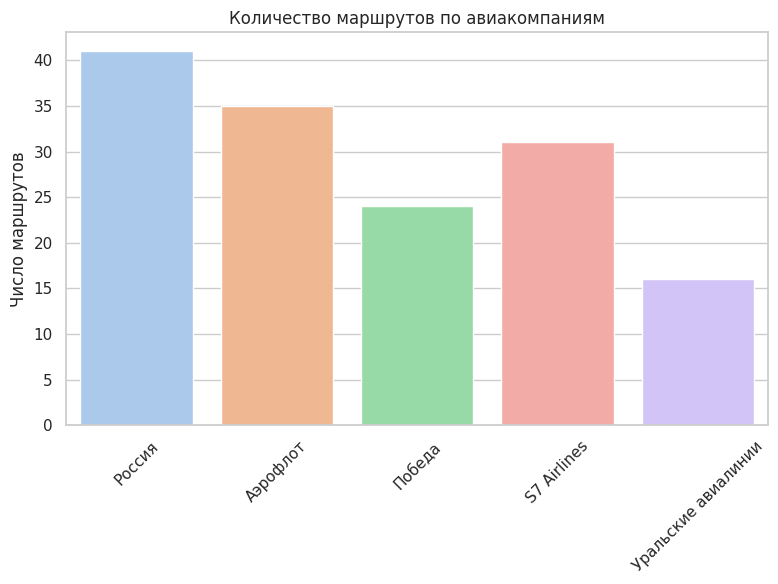

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=companies, y=route_counts, palette='pastel')

plt.title('Количество маршрутов по авиакомпаниям')
plt.ylabel('Число маршрутов')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Это отражает разницу в сети полётов: флагманские и лоукостеры покрывают разное число направлений.

Россия больше всего направлений покрывает.

## Анализ и визуализация

### Для анализа разброса цен построим "ящик с усами" (boxplot) по каждому перевозчику

In [ ]:
# сначала преобразуем данные в длинный формат

df_melt = df.melt(
    id_vars=['origin', 'dest'],
    value_vars=companies,
    var_name='Авиакомпания',
    value_name='Цена'
)

<ipython-input-37-1065e75841d8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Авиакомпания', y='Цена', data=df_melt, palette='muted')


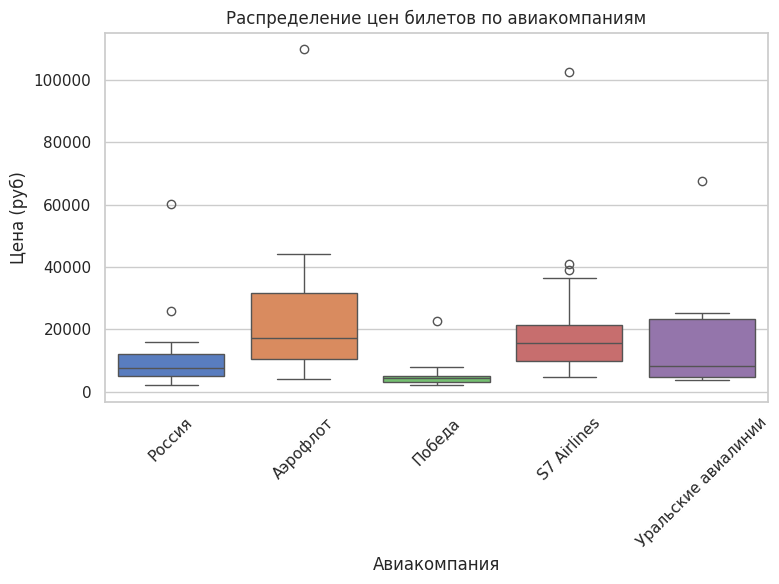

In [ ]:
# теперь строим
plt.figure(figsize=(8,6))
sns.boxplot(x='Авиакомпания', y='Цена', data=df_melt, palette='muted')

plt.title('Распределение цен билетов по авиакомпаниям')
plt.ylabel('Цена (руб)')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

* Лоукост Победа обеспечивает наиболее предсказуемые и дешёвые билеты по своим маршрутам

* Аэрофлот и S7 предлагают широкий диапазон цен, включая премиальные тарифы на дальние рейсы, что отражается в большом количестве верхних выбросов

* Уральские авиалинии демонстрируют среднее ценовое позиционирование, но при этом имеют как бюджетные, так и достаточно дорогие рейсы

* Россия занимает центральную нишу: цены выше Победы, но заметно ниже флагманов, с единичными дорогостоящими маршрутами.

### Далее сравним среднюю цену билета у каждой компании.

Построим столбчатую диаграмму среднего:

<ipython-input-39-b81811148bf3>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Авиакомпания', y='Цена', data=avg_price, palette='pastel')


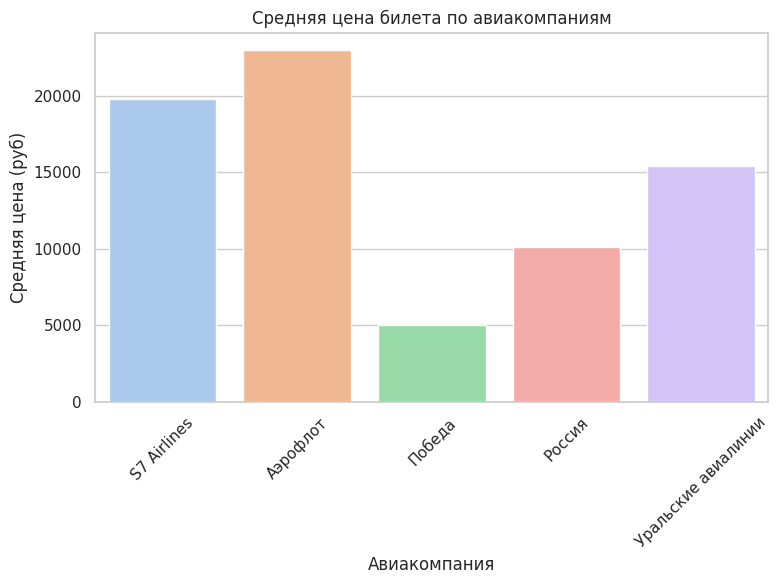

In [ ]:
plt.figure(figsize=(8,6))
avg_price = df_melt.groupby('Авиакомпания', as_index=False)['Цена'].mean()

sns.barplot(x='Авиакомпания', y='Цена', data=avg_price, palette='pastel')

plt.title('Средняя цена билета по авиакомпаниям')
plt.ylabel('Средняя цена (руб)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Видим, что Победа заметно дешевле всех (медианная цена ~5000 ₽) – это характерно для лоукост-модели

Аэрофлот и S7 — самые дорогие в среднем, но у них и покрытие шире, и предлагаются более комфортные/длинные рейсы

### Наконец, визуализируем среднюю цену по маршрутам.
Сначала добавим в таблицу столбец со средней ценой билета (среднее по компаниям, пропуски игнорируются):

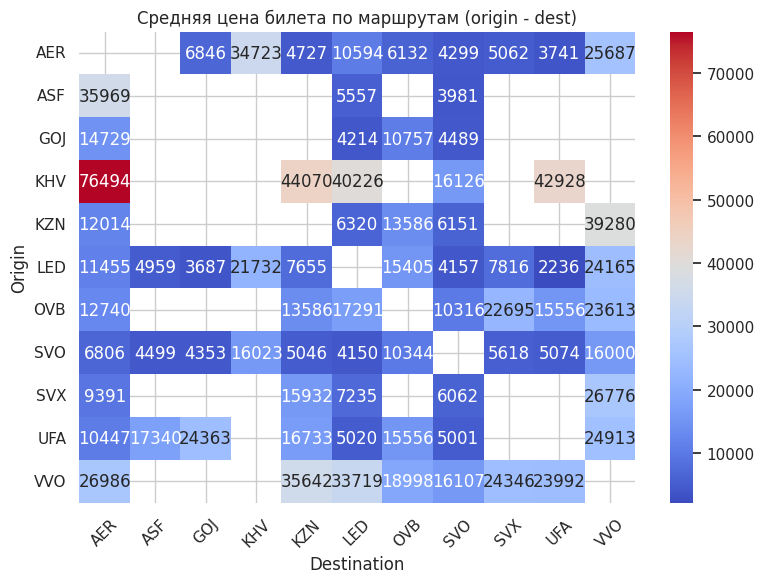

In [ ]:
df['Средняя цена'] = df[companies].mean(axis=1, skipna=True)

pivot_table = df.pivot(index='origin', columns='dest', values='Средняя цена')

plt.figure(figsize=(8,6))
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".0f")

plt.title('Средняя цена билета по маршрутам (origin - dest)')

plt.ylabel('Origin')
plt.xlabel('Destination')

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

На тепловой карте показаны средние цены билетов на каждом направлении. Яркие (красные) клетки соответствуют дорогим маршрутам, синие – более бюджетным.

Таким образом, самые дорогие рейсы связаны с перелётами на Дальний Восток и обратно, а бюджетные — внутри центрального региона (Москва–Питер и соседние направления).

## Выводы

**В ходе анализа цен на билеты по пяти авиакомпаниям (Победа, Россия, Уральские авиалинии, S7 Airlines и Аэрофлот) на маршрутах между крупнейшими городами России за 2025 год нашла следующие закономерности:**

1. Лоукост Победа стабильно предлагает самые выгодные тарифы: её средняя цена едва превышает 5 000 ₽, а разброс цен минимален — что делает её идеальным выбором для бюджетных поездок по доступным направлениям

2. Россия находится в среднем сегменте: медианная цена около 8 000 ₽, небольшое число дорогих выбросов говорит о единичных эксклюзивных рейсах, но в целом цены умеренны

3. Уральские авиалинии демонстрируют гибкую политику: средний билет стоит примерно 10 000 ₽, однако присутствуют как очень дешёвые, так и достаточно дорогие предложения, отражая широкий спектр маршрутов и тарифов

4. S7 Airlines и Аэрофлот занимают верхний ценовой сегмент: их средние цены — около 20–23 тыс. ₽ — формируются за счёт дальних направлений и премиальных услуг, что заметно по наличию множества выбросов в верхней части распределения

Таким образом, если наша задача — сэкономить и улететь по большинству популярных направлений внутри России, стоит обратить внимание на Победу;

если важен комфорт и широкий выбор услуг и мы готовы заплатить больше — оптимальным выбором будут S7 или Аэрофлот

## Обсуждение

* Что удалось: были собраны актуальные данные 2025 года с пяти крупных авиакомпаний и проведён сравнительный анализ цен по маршрутам.
Подготовлены наглядные графики (распределений, среднего и тепловой карты).

* Что можно улучшить: можно учитывать сезонность (разные даты и месяцы), расширить сбор данных на разные дни, добавить информацию о времени вылета или типе рейса (прямой/с пересадкой).
Можно также провести анализ загрузки рейсов или отзывов для комплексной оценки.

* Практическая польза: результаты помогают путешественникам и аналитикам быстро оценить, какая авиакомпания предлагает более доступные цены по нужному маршруту, а также увидеть общее представление о ценовой политике на различных направлениях.